In [22]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

In [23]:
RESULTS_LOCATION = './comparison_results/'
ENSEMBLES = ['ONSBoost', 'OB', 'OnlineBoosting', 'OOB', 'UOB']
METRICS = ['recall', 'specificity', 'precision', 'balanced_accuracy_score', 'f1_score', 'geometric_mean_score_1']
RST = [1000, 100000, 101010, 10110, 101101, 1001, 10101010, 101, 110, 1337]
BASE = ['GaussianNB', 'SGDClassifier']
STREAMS = ['cdi__w2_4_0,9', 'cdi__w2_5_0,75', 'disco__w2_5_0,9']
STREAMS_NAMES = {
    'cdi__w2_4_0,9': 'CDI1',
    'cdi__w2_5_0,75': 'CDI2',
    'disco__w2_5_0,9': 'DISCO1'
}
METRICS_NAMES = {
    'recall': 'czułość (recall)',
    'specificity': 'swoistość (specificity)',
    'precision': 'precyzja (precision)',
    'balanced_accuracy_score': 'zbalansowana dokładność (BAC)',
    'f1_score': 'F1',
    'geometric_mean_score_1': 'Gmean'
}
METRICS_NAMES_SHORT = {
    'recall': 'czułość',
    'specificity': 'swoistość',
    'precision': 'precyzja',
    'balanced_accuracy_score': 'BAC',
    'f1_score': 'F1',
    'geometric_mean_score_1': 'Gmean'
}

In [24]:
def load_all_data(directory: str):
    _results_files = [file for file in os.listdir(directory) if not os.path.isdir(os.path.join(directory, file))]
    _files = [(file, np.load(os.path.abspath(os.path.join(RESULTS_LOCATION, file)))) for file in _results_files]
    acc = []
    for file, data in _files:
        rst = file.split('__RST_')[1].split('.')[0]
        stream = file.split('++')[1].split('__NC')[0]
        base_clf = file.split('++')[0]
        for i, ensemble in enumerate(ENSEMBLES):
            current = {
                'base': base_clf,
                'rst': rst,
                'stream': stream,
                'ensemble': ensemble
            }
            for j, metric in enumerate(METRICS):
                mean = data[i, :, j].mean(axis=0)
                current[metric] = mean
            acc.append(current)

    return pd.DataFrame(acc)


all_data = load_all_data(RESULTS_LOCATION)
all_data

,base,rst,stream,ensemble,recall,specificity,precision,balanced_accuracy_score,f1_score,geometric_mean_score_1
0,GaussianNB,1000,"cdi__w2_4_0,9",ONSBoost,0.889260,0.858786,0.919403,0.874023,0.900033,0.864386
1,GaussianNB,1000,"cdi__w2_4_0,9",OB,0.835575,0.869914,0.788768,0.852745,0.797915,0.850585
2,GaussianNB,1000,"cdi__w2_4_0,9",OnlineBoosting,0.905354,0.801743,0.895125,0.853549,0.897123,0.839996
3,GaussianNB,1000,"cdi__w2_4_0,9",OOB,0.851056,0.860095,0.772989,0.855575,0.793877,0.854388
4,GaussianNB,1000,"cdi__w2_4_0,9",UOB,0.856820,0.854914,0.765509,0.855867,0.790361,0.854755
...,...,...,...,...,...,...,...,...,...,...
295,SGDClassifier,1337,"disco__w2_5_0,9",ONSBoost,0.795506,0.809934,0.812636,0.802720,0.794158,0.780106
296,SGDClassifier,1337,"disco__w2_5_0,9",OB,0.817984,0.843381,NaN,0.830682,0.834163,0.805913
297,SGDClassifier,1337,"disco__w2_5_0,9",OnlineBoosting,0.795090,0.812038,0.807783,0.803564,0.792668,0.783257
298,SGDClassifier,1337,"disco__w2_5_0,9",OOB,0.868403,0.862145,0.791521,0.865274,0.815429,0.861771


In [25]:
def extract_data_for(df: pd.DataFrame, base: str, stream: str, ensemble: str):
    return df[(df['base'] == base) & (df['stream'] == stream) & (df['ensemble'] == ensemble)]


def draw_boxplot_for(df: pd.DataFrame, base: str, stream: str, metric: str) -> plt.Figure:
    fig, ax = plt.subplots()
    boxplot_data = np.zeros((len(RST), len(ENSEMBLES))).T
    for i, ensemble in enumerate(ENSEMBLES):
        ensemble_scores = extract_data_for(df, base, stream, ensemble)
        ensemble_scores = ensemble_scores[metric].to_numpy()
        boxplot_data[i] = ensemble_scores
    ax.boxplot(boxplot_data.T, labels=ENSEMBLES)
    ax.set_ylabel(METRICS_NAMES[metric])
    ax.set_xlabel('zespół klasyfikatorów')
    fig.suptitle(f'{base} / {STREAMS_NAMES[stream]} / {METRICS_NAMES[metric]}')
    return fig


def draw_all_boxplots(df: pd.DataFrame):
    for base in BASE:
        for stream in STREAMS:
            for metric in METRICS:
                # fig = draw_boxplot_for(df, base, stream, metric)
                # fig.savefig(f'{base}-{STREAMS_NAMES[stream]}-{metric}.svg')
                pass


draw_all_boxplots(all_data)

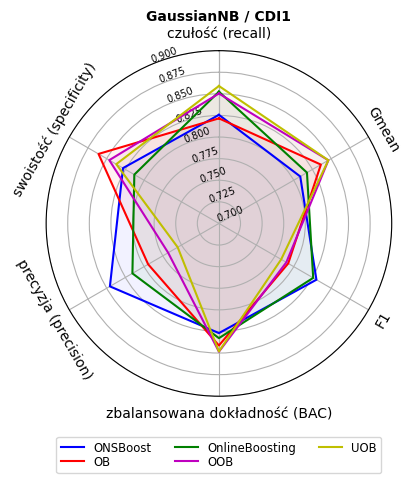

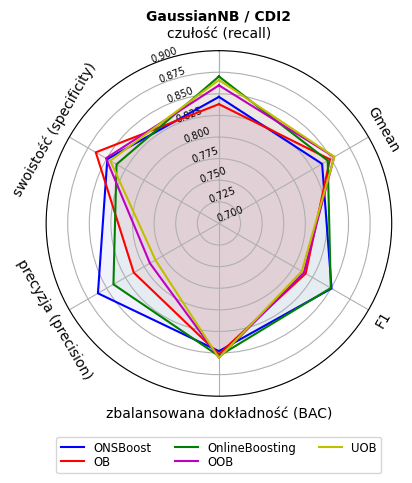

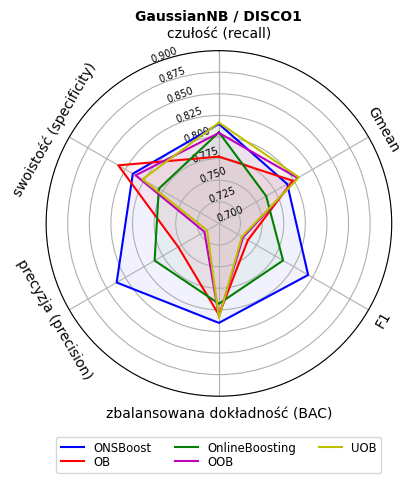

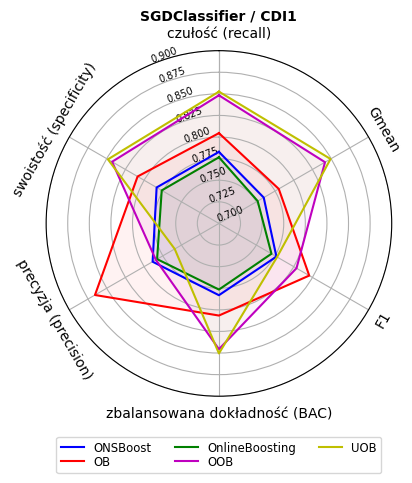

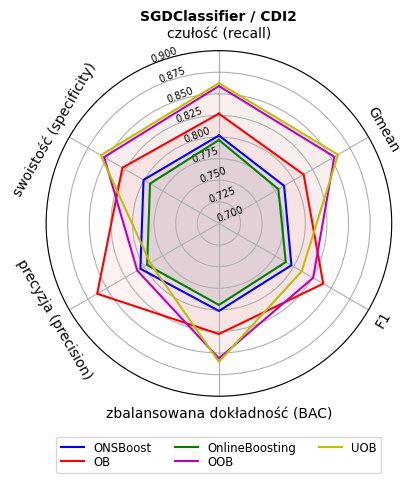

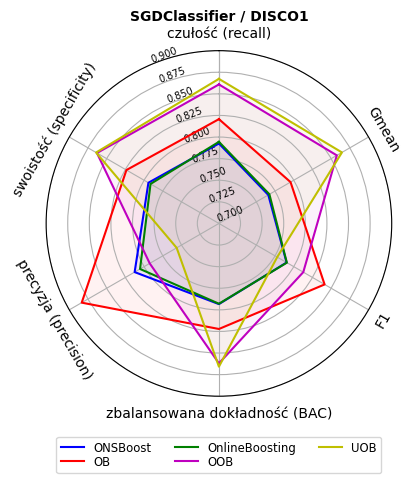

In [205]:
def draw_polar(data, title=None):
    metrics_names = list(METRICS_NAMES.values())
    N = len(metrics_names)
    fig, ax = plt.subplots(subplot_kw=dict(polar=True))
    label_loc = np.linspace(start=0, stop=2 * np.pi, num=N + 1)
    ax.set_theta_zero_location('N')
    plt.thetagrids(np.degrees(label_loc), labels=[] * N)
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)
    colors = ['b', 'r', 'g', 'm', 'y']
    if title:
        ax.text(0, -.2, title, ha='center', va='center', transform=ax.get_xaxis_text1_transform(-10)[0],
            fontweight='bold')
    ax.set_ylim(.7, .9)
    ax.yaxis.set_tick_params(labelsize=7, rotation=21)
    for d, color in zip(data, colors):
        ax.plot(label_loc, [*d, d[0]], color=color)
        ax.fill(label_loc, [*d, d[0]], facecolor=color, alpha=0.05, label='_nolegend_')

    for i, metric in enumerate(metrics_names):
        trans, _, _ = ax.get_xaxis_text1_transform(-10)
        rotation = i * 360 / N + (0 if i in [0, 1, 5] else 180)
        ax.text(np.deg2rad(i * 360 / N), -0.1, metric, transform=trans,
                rotation=rotation, ha="center", va="center")

    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 0.9])

    # Put a legend below current axis
    ax.legend(ENSEMBLES, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize='small', labelspacing=.1)
    return fig

def draw_polar_for(df: pd.DataFrame, base: str, stream: str):
    _df = df.groupby(by=['base', 'stream', 'ensemble'], group_keys=False).mean()
    _df = _df.loc[base, stream].drop(['rst'], axis=1)
    _data = np.zeros((len(ENSEMBLES), len(METRICS)))
    _title = f'{base} / {STREAMS_NAMES[stream]}'
    for i, ensemble in enumerate(ENSEMBLES):
        _data[i] = _df.loc[ensemble].to_numpy()
    return draw_polar(_data, title=_title)

def prepare_polars(df: pd.DataFrame):
    for base in BASE:
        for stream in STREAMS:
            _fig = draw_polar_for(df, base, stream)
            plt.savefig(f'{base}-{STREAMS_NAMES[stream]}.svg')

prepare_polars(all_data)